In [1]:
# Importing Modules 
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load one of the indices and clean the data
def load_index(path, stdev_window=5, mean_window=5):
    
    df = pd.read_csv(path, parse_dates=True, infer_datetime_format=True, index_col="Date" )

    # Compute stdev
    df['stdev'] = df['Close'].pct_change().rolling(window=stdev_window).std()
    
    # Smooth the data
    for column in df:    
        df[column] = df[column].rolling(window=mean_window).mean()  
    
    df.dropna(inplace=True)
    # print(df.shape)
    print('Data loaded')
    # display(df.head(3))
    
    return df

# index_path = './DATA/INDICES/SP_OHLCV.csv'
# stdev_window = 25
# mean_window = 10
# df_SP = load_index(index_path, stdev_window, mean_window)
# df_SP.stdev.plot(figsize=(16, 10));

In [3]:
# Function for plotting grids with matplotlib
def plot_grid(df, nrows, ncols):
    
    fix, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, linewidth=1)
        
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
        
    plt.tight_layout();
    
# Plot dataset
# plot_grid(df_SP[['Close', 'stdev', 'Volume']], 3, 1)

In [4]:
# Check stationarity
def check_stationarity(df, n_diffs=0):
    
    n_diffs = n_diffs
    non_stationary = []
    
    for column in df:
        adfuller_res = adfuller(df[column][1:])
        adf_stat, p_value = adfuller_res[0], adfuller_res[1]
        ci_1, ci_5 = adfuller_res[-2]['1%'], adfuller_res[-2]['5%']
        # print(f'ADF Statistic ({column}): {adf_stat}')
        # print(f'p-value: {p_value}')
        if (adf_stat > ci_1) or (adf_stat > ci_5):
            non_stationary.append(column)
            # print(f'{column} is non stationary.')
        # else:
            # print(f'{column} is stationary!')

    if len(non_stationary) == 0:
        # print(f'All columns are stationary!')
        return df
    
    else:
        df = pd.concat([df[non_stationary].diff(), df.drop(columns=non_stationary)], axis=1).dropna()
        n_diffs += 1
        
        # print(f'Non-stationary columns still exist\nPerforming .diff(): count {n_diffs}')
        return check_stationarity(df, n_diffs), n_diffs
    
# df_SP, n_diffs  = check_stationarity(df_SP)

In [5]:
# Scale the data with MaxAbsScaler
def scale_data(df, n_diffs, n_train, stdev_window, mean_window):

    # Create scaler
    scaler = MaxAbsScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns).dropna()

    # Split data
    n_test = len(df) - n_train - n_diffs - stdev_window - mean_window
    df_train = df_scaled.iloc[:n_train]
    df_test = df_scaled.iloc[n_train:n_test+n_train]

    # Create separate test set to preserve index for plotting predictions later
    df_pred_index = df.iloc[n_train:n_test+n_train]

    # print(f'Number of training days: {n_train}')
    print(f'Number of testing days: {n_test}')

    # display(df_train.head(3))
    # display(df_test.head(3))
    
    return df_train, df_test, df_pred_index, n_test
    
# n_train = 2500
# df_train, df_test, df_pred_index, n_test = scale_data(df_SP, n_diffs, n_train, stdev_window)

In [6]:
# Source:
# https://goldinlocks.github.io/Multivariate-time-series-models/
# 
# Create VARMAX model & find the best p,q combination
# NOTE: WARNING!!!, this might take a LONG time to run!!!

def check_p_q(df_train, n_tocheck):
    
    test_results = {}
    
    # How many values to check for p & q
    n_tocheck += 1
    
    for p in range(n_tocheck):
        for q in range(n_tocheck):
            if p == 0 and q == 0:
                continue
                
            print(f'Testing order: p = {p}, q = {q}..')
            convergence_error, stationarity_error = 0, 0
            
            try:
                
                model = VARMAX(
                    df_train,
                    order = (p,q),
                    # trend = 'n',
                    filter_concentrated=True
                )
                model_result = model.fit(maxiter=1000, disp=False)
                    
            except np.linalg.LinAlgError:
                convergence_error += 1
                    
            except ValueError:
                stationarity_error += 1
                    
            # print('\nAIC:', model_result.aic)
            # print('BIC:', model_result.bic)
            # print('HQIC:', model_result.hqic)
            # print('------------------------')

            test_results[(p, q)] = [model_result.aic,
                                    model_result.bic,
                                    convergence_error,
                                    stationarity_error]
    
    print('Done testing.')
    return test_results

# test_results = check_p_q(df_train)


In [7]:
# Source:
# https://goldinlocks.github.io/Multivariate-time-series-models/

def analyze_order(test_results):
    
    # Create test results dataframe
    test_results = pd.DataFrame(test_results).T
    test_results.columns = ['AIC', 'BIC', 'convergence', 'stationarity']
    test_results.index.names = ['p', 'q']
    # test_results.info()
    
    # We want to minimize BIC
    # Visualize the values with a heatmap
    sns.heatmap(test_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues_r')
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show()
    
    # Get the best model
    # display(test_results.sort_values('BIC').head(3))
    p_best,q_best = test_results.sort_values('BIC').iloc[0].name
    print(f'Best p-value: {p_best}')
    print(f'Best q-value: {q_best}')
    
    return p_best, q_best

# p_best, q_best = analyze_order(test_results)

In [8]:
def create_varmax(df_train, p_best, q_best):

    # Split exogenous and endogenous variables
    # endog = df_train.drop(columns=['Volume'])
    # exog = df_train['Volume']

    # Create VARMAX Model
    model = VARMAX(
        df_train,
        order=(p_best,q_best),
        # trend = 'n',
        # order=(1,2),
        # error_cov_type='diagonal',
        filter_concentrated=True
    )

    # Fit model
    print('Fitting model.. Please wait..')
    model_fit = model.fit(disp=True)
    # model_fit.summary()
    
    return model_fit

# model_fit = create_varmax(df_train, p_best, q_best)

In [9]:
def analyze_predictions(model_fit, df_test, df_pred_index, n_test):

    # Set random seed
    np.random.seed(1)

    # Predicted vs observed volatility
    pred = pd.DataFrame(index=df_pred_index.index)
    pred['prediction'] = model_fit.simulate(n_test).set_index(pred.index, drop=True).stdev
    pred['observed'] = df_test.set_index(pred.index, drop=True).stdev

    # Plot error
    pred['prediction - observed'] = pred['prediction'] - pred['observed']
    pred.plot(figsize=(20,5),title='volatility forecast error',color=['blue','purple','green'],style=['-','-',':'])
    plt.legend(loc=('upper left'));
    
    return pred

# pred = analyze_predictions(model_fit, df_pred_index, n_test, df_test)

In [10]:
def find_error(pred):
    
    error_total = np.round(np.sum(np.abs(pred['prediction - observed'])), 2)
    # print(f'Total Error: {error_total}')
    
    return error_total
    
# error_total = find_error(pred)

-----------------------------
Stdev window: 5
Mean window: 5
Data loaded
Number of testing days: 505
Fitting model.. Please wait..
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28270D+01    |proj g|=  4.99500D+01


 This problem is unconstrained.



At iterate    1    f= -1.28345D+01    |proj g|=  2.59814D+01

At iterate    2    f= -1.28387D+01    |proj g|=  5.14941D+00

At iterate    3    f= -1.28392D+01    |proj g|=  3.39920D+00

At iterate    4    f= -1.28407D+01    |proj g|=  4.59487D+00

At iterate    5    f= -1.28415D+01    |proj g|=  3.39126D+00

At iterate    6    f= -1.28432D+01    |proj g|=  4.13105D+00

At iterate    7    f= -1.28448D+01    |proj g|=  5.11158D+00

At iterate    8    f= -1.28469D+01    |proj g|=  6.18767D+00

At iterate    9    f= -1.28536D+01    |proj g|=  9.93969D+00

At iterate   10    f= -1.28631D+01    |proj g|=  8.02811D+00

At iterate   11    f= -1.28743D+01    |proj g|=  6.87590D+00

At iterate   12    f= -1.28859D+01    |proj g|=  6.77082D+00

At iterate   13    f= -1.28922D+01    |proj g|=  2.81806D+01

At iterate   14    f= -1.29004D+01    |proj g|=  1.04227D+01

At iterate   15    f= -1.29058D+01    |proj g|=  7.76711D+00

At iterate   16    f= -1.29154D+01    |proj g|=  5.10251D+00

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48241D+01    |proj g|=  3.23262D+01

At iterate    1    f= -1.48326D+01    |proj g|=  4.00584D+01

At iterate    2    f= -1.48397D+01    |proj g|=  1.52747D+01

At iterate    3    f= -1.48416D+01    |proj g|=  9.03002D+00

At iterate    4    f= -1.48423D+01    |proj g|=  6.68184D+00

At iterate    5    f= -1.48430D+01    |proj g|=  5.11667D+00

At iterate    6    f= -1.48433D+01    |proj g|=  2.68228D+00

At iterate    7    f= -1.48437D+01    |proj g|=  6.48506D+00

At iterate    8    f= -1.48443D+01    |proj g|=  8.24393D+00

At iterate    9    f= -1.48448D+01    |proj g|=  8.73314D+00

At iterate   10    f= -1.48449D+01    |proj g|=  7.00333D+00

At iterate   11    f= -1.48453D+01    |proj g|=  3.33248D+00

At iterate   12    f= -1.48457D+01    |proj g|=  4.68071D+00

At iterate   13    f= -1.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57221D+01    |proj g|=  4.87560D+01

At iterate    1    f= -1.57305D+01    |proj g|=  3.64298D+01

At iterate    2    f= -1.57375D+01    |proj g|=  2.23530D+01

At iterate    3    f= -1.57400D+01    |proj g|=  8.69523D+00

At iterate    4    f= -1.57405D+01    |proj g|=  9.01527D+00

At iterate    5    f= -1.57409D+01    |proj g|=  3.87588D+00

At iterate    6    f= -1.57410D+01    |proj g|=  2.50826D+00

At iterate    7    f= -1.57413D+01    |proj g|=  5.81192D+00

At iterate    8    f= -1.57415D+01    |proj g|=  7.85032D+00

At iterate    9    f= -1.57418D+01    |proj g|=  8.69854D+00

At iterate   10    f= -1.57419D+01    |proj g|=  6.27061D+00

At iterate   11    f= -1.57420D+01    |proj g|=  4.41209D+00

At iterate   12    f= -1.57420D+01    |proj g|=  4.96797D+00

At iterate   13    f= -1.5


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135     19     73      2     0     0   1.260D+01  -1.574D+01
  F =  -15.742535063901261     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Total error: 60.7
-----------------------------
Stdev window: 5
Mean window: 20
Data loaded
Number of testing days: 475
Fitting model.. Please wait..


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66953D+01    |proj g|=  4.54521D+01

At iterate    1    f= -1.66997D+01    |proj g|=  3.60550D+01

At iterate    2    f= -1.67056D+01    |proj g|=  6.35447D+01

At iterate    3    f= -1.67099D+01    |proj g|=  4.42921D+01

At iterate    4    f= -1.67112D+01    |proj g|=  1.19518D+01

At iterate    5    f= -1.67115D+01    |proj g|=  1.05429D+01

At iterate    6    f= -1.67121D+01    |proj g|=  1.04416D+01

At iterate    7    f= -1.67123D+01    |proj g|=  9.06205D+00

At iterate    8    f= -1.67124D+01    |proj g|=  1.08629D+01

At iterate    9    f= -1.67125D+01    |proj g|=  1.23219D+01

At iterate   10    f= -1.67126D+01    |proj g|=  1.44991D+01

At iterate   11    f= -1.67127D+01    |proj g|=  1.37713D+01

At iterate   12    f= -1.67128D+01    |proj g|=  1.33569D+01

At iterate   13    f= -1.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   17    f= -1.67129D+01    |proj g|=  5.96752D+00

At iterate   18    f= -1.67131D+01    |proj g|=  5.96087D+00

At iterate   19    f= -1.67134D+01    |proj g|=  1.28812D+01

At iterate   20    f= -1.67136D+01    |proj g|=  7.80190D+00

At iterate   21    f= -1.67137D+01    |proj g|=  1.02125D+01

At iterate   22    f= -1.67139D+01    |proj g|=  9.83314D+00

At iterate   23    f= -1.67140D+01    |proj g|=  1.16324D+01

At iterate   24    f= -1.67141D+01    |proj g|=  9.31314D+00

At iterate   25    f= -1.67142D+01    |proj g|=  8.43113D+00

At iterate   26    f= -1.67144D+01    |proj g|=  8.16085D+00

At iterate   27    f= -1.67144D+01    |proj g|=  6.87288D+00

At iterate   28    f= -1.67145D+01    |proj g|=  9.03610D+00

At iterate   29    f= -1.67145D+01    |proj g|=  8.95806D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Total error: 69.91
-----------------------------
Stdev window: 5
Mean window: 25
Data loaded
Number of testing days: 465
Fitting model.. Please wait..
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71037D+01    |proj g|=  9.33181D+01


 This problem is unconstrained.



At iterate    1    f= -1.71124D+01    |proj g|=  4.40242D+01

At iterate    2    f= -1.71154D+01    |proj g|=  3.23806D+01

At iterate    3    f= -1.71191D+01    |proj g|=  1.84122D+01

At iterate    4    f= -1.71202D+01    |proj g|=  1.45443D+01

At iterate    5    f= -1.71208D+01    |proj g|=  1.04126D+01

At iterate    6    f= -1.71209D+01    |proj g|=  8.23995D+00

At iterate    7    f= -1.71210D+01    |proj g|=  1.08898D+01

At iterate    8    f= -1.71210D+01    |proj g|=  1.19396D+01

At iterate    9    f= -1.71211D+01    |proj g|=  1.29308D+01

At iterate   10    f= -1.71211D+01    |proj g|=  1.35455D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   11    f= -1.71213D+01    |proj g|=  1.99488D+01

At iterate   12    f= -1.71217D+01    |proj g|=  1.01456D+01

At iterate   13    f= -1.71218D+01    |proj g|=  7.34319D+00

At iterate   14    f= -1.71218D+01    |proj g|=  9.91290D+00

At iterate   15    f= -1.71218D+01    |proj g|=  1.10187D+01

At iterate   16    f= -1.71218D+01    |proj g|=  1.19601D+01

At iterate   17    f= -1.71218D+01    |proj g|=  1.20603D+01

At iterate   18    f= -1.71218D+01    |proj g|=  1.21680D+01

At iterate   19    f= -1.71218D+01    |proj g|=  1.23061D+01

At iterate   20    f= -1.71218D+01    |proj g|=  1.26882D+01

At iterate   21    f= -1.71218D+01    |proj g|=  1.28003D+01

At iterate   22    f= -1.71218D+01    |proj g|=  1.31918D+01

At iterate   23    f= -1.71218D+01    |proj g|=  1.27677D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate    1    f=          NaN    |proj g|=          NaN


LinAlgError: Schur decomposition solver error.

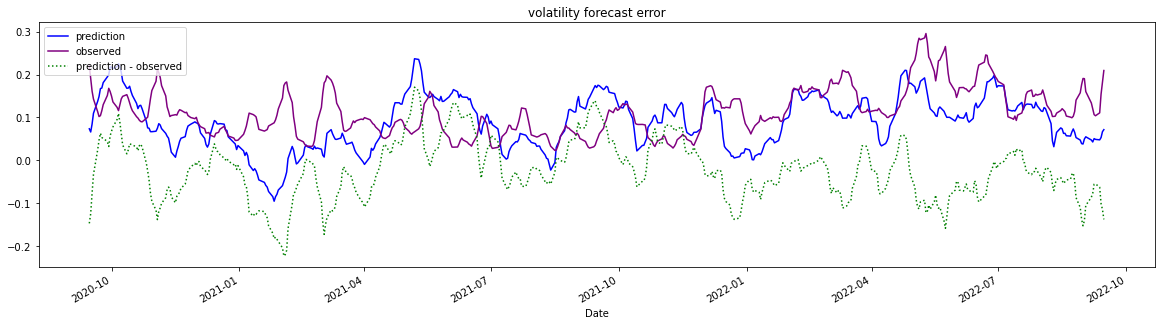

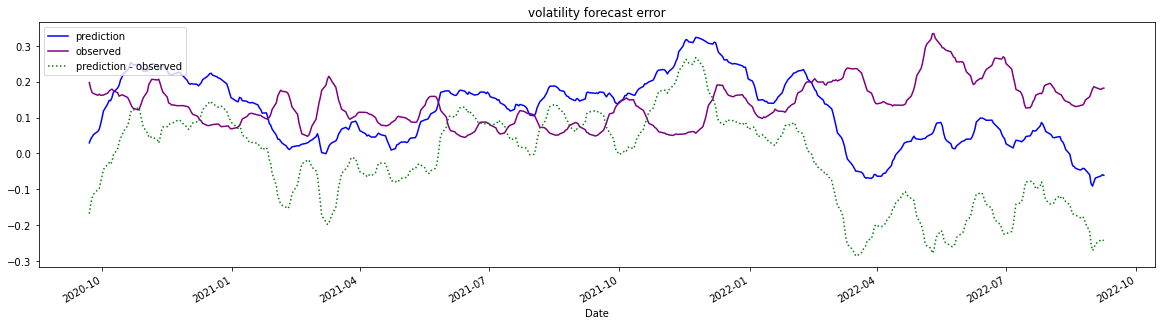

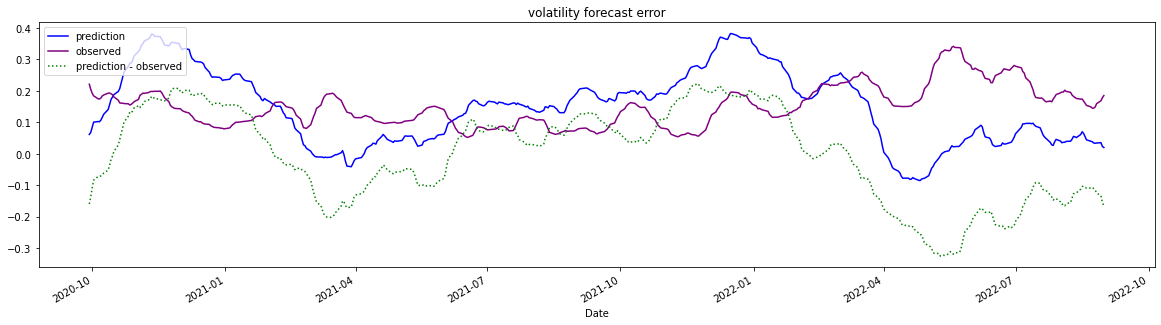

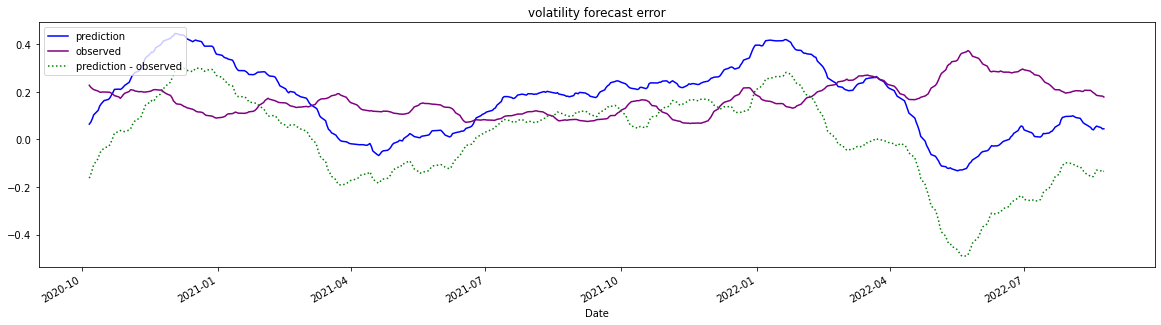

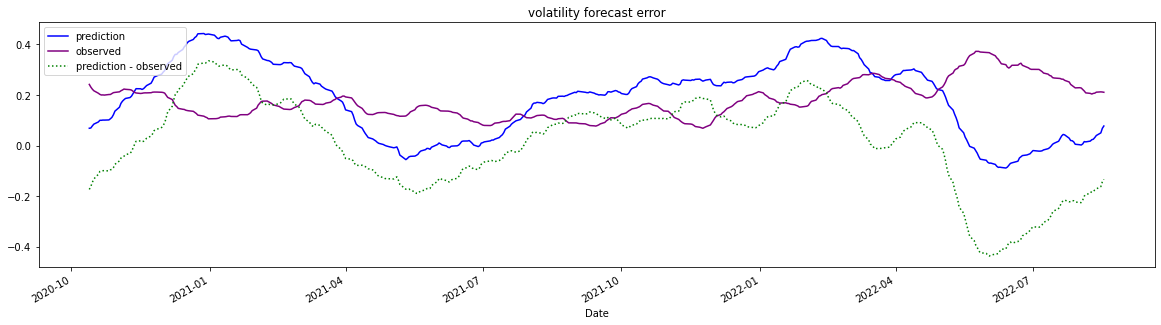

In [11]:
# Alternate version of the function to check for best rolling windows:
# ---------------------------------------------
# Results of Stdev window test:
# 35 - 46.21
# 40 - 37.71
# 45 - 37.52
# 50 - 44.29
# 45 gives lowest error
# ---------------------------------------------
# Results of Mean window test:
# 25 - 35.88
# 30 - 27.75
# 35 - 25.82
# 40 - 45.17
# 45 - 20.28
# 50 - 43.24
# 45 gives best error
# ---------------------------------------------

def run_varmax_predictions_test(stdev_windows, mean_windows):
    
    results = {}
    
    for stdev_window in stdev_windows:
        for mean_window in mean_windows:
            
            print('-----------------------------')
            print(f'Stdev window: {stdev_window}')
            print(f'Mean window: {mean_window}')
            
            path = './DATA/INDICES/SP_OHLCV.csv'

            df_SP = load_index(path, stdev_window, mean_window)
            # plot_grid(df_SP[['Close', 'stdev', 'Volume']], 3, 1)

            df_SP, n_diffs  = check_stationarity(df_SP)

            n_train = 2500
            df_train, df_test, df_pred_index, n_test = scale_data(df_SP, n_diffs, n_train, stdev_window, mean_window)

            # Uncomment these lines below to check for best p & q
            # It will take a long time
            # --------------------------------------------------
            # test_results = check_p_q(df_train, 3)
            # p_best, q_best = analyze_order(test_results)

            # Setting p, q manually - 1,2 found to give best fit
            p_best, q_best = 1, 2
            model_fit = create_varmax(df_train, p_best, q_best)

            # Plot stdev diagnostics
            # model_fit.plot_diagnostics(5,figsize=(20,8));

            pred = analyze_predictions(model_fit, df_test, df_pred_index, n_test)
            error_total = find_error(pred)
            
            results[(stdev_window, mean_window)] = error_total
            
            # print(f'Mean window: {mean_window}')
            # print(f'Stdev window: {stdev_window}')
            print(f'Total error: {error_total}')
            
    return results

stdev_windows = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
mean_windows = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
# mean_windows, stdev_windows = [5], [5]
results = run_varmax_predictions_test(stdev_windows, mean_windows)


Data loaded
Number of testing days: 345
Fitting model.. Please wait..
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71331D+01    |proj g|=  2.67601D+02


 This problem is unconstrained.



At iterate    1    f= -1.71645D+01    |proj g|=  2.88564D+02

At iterate    2    f= -1.71984D+01    |proj g|=  3.01516D+02

At iterate    3    f= -1.73183D+01    |proj g|=  2.36740D+02

At iterate    4    f= -1.73293D+01    |proj g|=  5.61601D+01

At iterate    5    f= -1.73298D+01    |proj g|=  3.50244D+01

At iterate    6    f= -1.73307D+01    |proj g|=  7.46263D+01

At iterate    7    f= -1.73318D+01    |proj g|=  1.39938D+02

At iterate    8    f= -1.73325D+01    |proj g|=  1.42586D+02

At iterate    9    f= -1.73370D+01    |proj g|=  1.82260D+02

At iterate   10    f= -1.73525D+01    |proj g|=  9.81606D+01

At iterate   11    f= -1.73694D+01    |proj g|=  8.59469D+01

At iterate   12    f= -1.73896D+01    |proj g|=  9.71016D+01

At iterate   13    f= -1.74042D+01    |proj g|=  7.53765D+01

At iterate   14    f= -1.74104D+01    |proj g|=  2.92396D+01

At iterate   15    f= -1.74140D+01    |proj g|=  6.89607D+01

At iterate   16    f= -1.74158D+01    |proj g|=  5.29493D+01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   29    f= -1.74378D+01    |proj g|=  9.25880D+01

At iterate   30    f= -1.74384D+01    |proj g|=  2.48705D+01

At iterate   31    f= -1.74384D+01    |proj g|=  1.60785D+01

At iterate   32    f= -1.74385D+01    |proj g|=  1.75794D+01

At iterate   33    f= -1.74386D+01    |proj g|=  1.95714D+01

At iterate   34    f= -1.74386D+01    |proj g|=  2.66589D+01

At iterate   35    f= -1.74390D+01    |proj g|=  4.71348D+01

At iterate   36    f= -1.74392D+01    |proj g|=  4.55463D+01

At iterate   37    f= -1.74407D+01    |proj g|=  4.17054D+01

At iterate   38    f= -1.74429D+01    |proj g|=  2.71261D+01

At iterate   39    f= -1.74446D+01    |proj g|=  1.30912D+01

At iterate   40    f= -1.74451D+01    |proj g|=  1.38727D+01

At iterate   41    f= -1.74461D+01    |proj g|=  4.50115D+01

At iterate   42    f= -1.74463D+01    |proj g|=  2.38351D+01

At iterate   43    f= -1.74464D+01    |proj g|=  2.71156D+01

At iterate   44    f= -1.74466D+01    |proj g|=  3.67532D+01

At iter

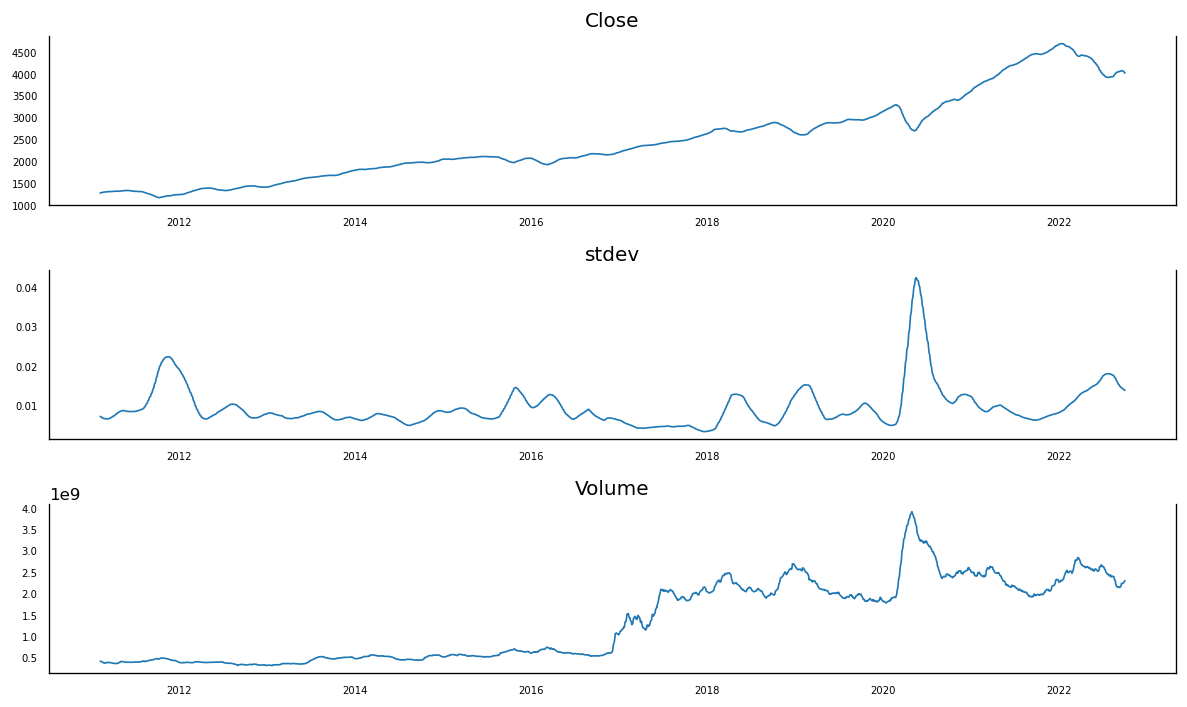

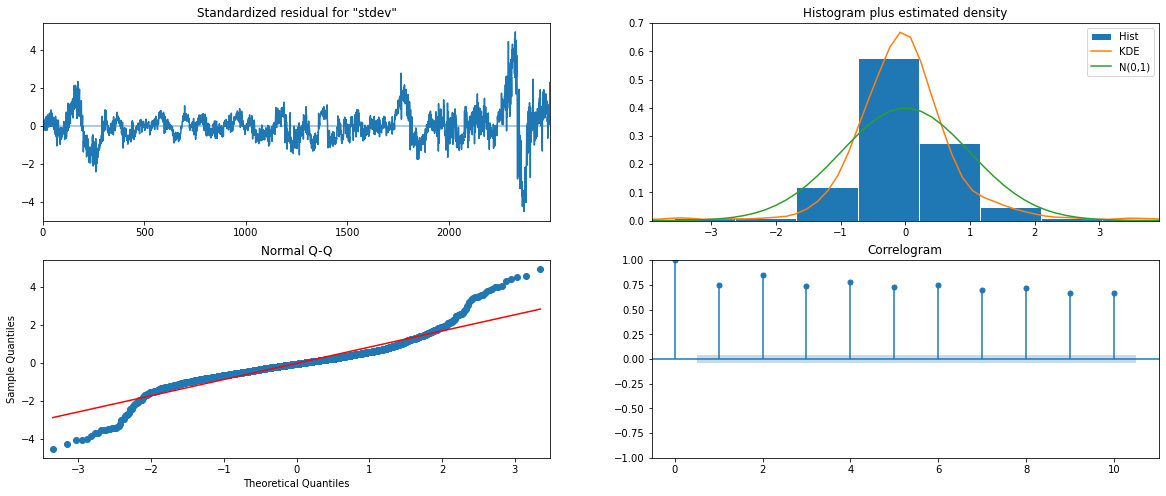

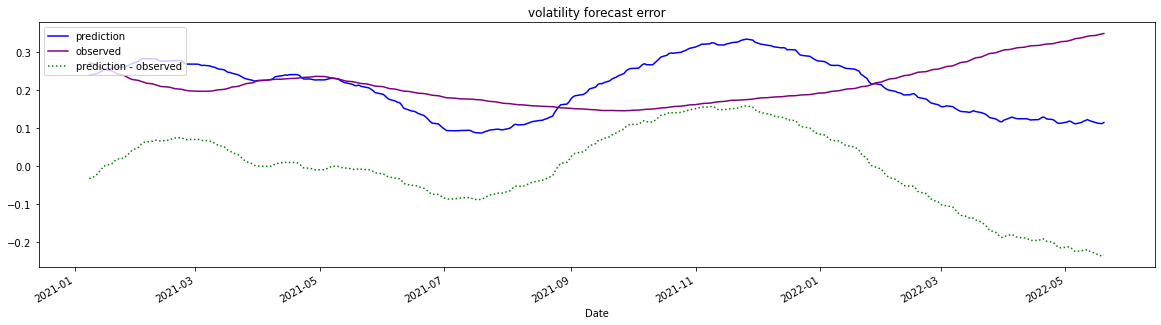

In [12]:
# ==================================================
# Run Everything
# ==================================================

def run_varmax_predictions():
    
    path = './DATA/INDICES/SP_OHLCV.csv'
    stdev_window = 45
    mean_window = 45

    df_SP = load_index(path, stdev_window, mean_window)
    plot_grid(df_SP[['Close', 'stdev', 'Volume']], 3, 1)

    df_SP, n_diffs  = check_stationarity(df_SP)

    n_train = 2500
    df_train, df_test, df_pred_index, n_test = scale_data(df_SP, n_diffs, n_train, stdev_window, mean_window)

    # Uncomment these lines below to check for best p & q
    # It will take a long time
    # --------------------------------------------------
    # test_results = check_p_q(df_train, 3)
    # p_best, q_best = analyze_order(test_results)

    # Setting p, q manually - 1,2 found to give best fit
    p_best, q_best = 1, 2
    model_fit = create_varmax(df_train, p_best, q_best)

    # Plot stdev diagnostics
    model_fit.plot_diagnostics(5,figsize=(20,8));

    pred = analyze_predictions(model_fit, df_test, df_pred_index, n_test)
    error_total = find_error(pred)
    print(f'Total error: {error_total}')
    
    # return pred
    
run_varmax_predictions()
